Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Some trails :

In [39]:
import re
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
#tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
#Classification
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
#Metrics 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss, make_scorer

In [40]:
all_data = pd.read_csv("train_ml.csv", index_col=0)

all_data_final = pd.read_csv("test_ml.csv", index_col=0)

In [41]:
def format_date(row):
    pattern = r'(\d{1,2}.*\d{2}:\d{2}:\d{2}) ([+-]\d{2}\d{2})'
    
    ans = re.search(pattern, string=row)
    
    if ans:
        if ans.group(1)[1] == ' ':
            return ''.join(['0', ans.group(1), ans.group(2)])
        else:
            return ''.join([ans.group(1), ans.group(2)])
    else:
        return "1900-01-01 15:00:00+0000"

#The for loops are slow :

all_data['date'] = pd.to_datetime(all_data['date'].apply(format_date), utc=True)
tmp_1 = []
tmp_2 = []
for d in all_data['date']:
    tmp_1.append(d.strftime("%A"))
    tmp_2.append(d.strftime("%H"))
all_data['date'] = tmp_1
all_data['date_hour'] = tmp_2


all_data_final['date'] = pd.to_datetime(all_data_final['date'].apply(format_date), utc=True)
tmp_1 = []
tmp_2 = []
for d in all_data_final['date']:
    tmp_1.append(d.strftime("%A"))
    tmp_2.append(d.strftime("%H"))
all_data_final['date'] = tmp_1
all_data_final['date_hour'] = tmp_2

In [42]:
all_data['date'].nunique()

7

In [43]:
all_data

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,...,chars_in_body,updates,personal,promotions,forums,purchases,travel,spam,social,date_hour
0,Monday,researchgatemail,net,0,0,multipart/alternative,4,28,0,1,...,25556,0,1,0,0,0,0,0,1,08
1,Thursday,no-ip,com,0,0,multipart/alternative,6,32,0,0,...,19930,1,1,0,0,0,0,0,0,16
2,Thursday,mail,goodreads.com,0,0,multipart/mixed,0,0,0,0,...,4,0,1,0,0,0,0,0,1,01
3,Friday,insideapple,apple.com,0,0,multipart/alternative,108,171,0,0,...,96568,0,0,1,0,0,0,0,0,08
4,Thursday,twitter,com,0,0,multipart/alternative,20,166,0,0,...,95131,0,1,0,0,0,0,0,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39666,Tuesday,mp1,tripadvisor.com,0,0,text/html,11,31,0,0,...,44952,0,0,1,0,0,0,0,0,18
39667,Tuesday,NaN,NaN,0,0,text/plain,0,0,0,0,...,721,1,1,0,0,0,0,0,0,10
39668,Monday,iiitd,ac.in,0,0,multipart/alternative,0,0,1,0,...,571,0,1,0,1,0,0,0,0,13
39669,Thursday,m,mail.coursera.org,0,0,multipart/alternative,27,136,1,1,...,92847,1,1,0,0,0,0,0,0,00


### Lets create more features :

In [44]:
all_data["sub/body"] = all_data.chars_in_subject / all_data.chars_in_body
all_data["urls/body"] = all_data.urls/all_data.chars_in_body
all_data["images/body"] = all_data.images/all_data.chars_in_body
all_data["salutaions&designation"] = all_data.salutations*all_data.designation

all_data_final["sub/body"] = all_data_final.chars_in_subject / all_data_final.chars_in_body
all_data_final["urls/body"] = all_data_final.urls/all_data_final.chars_in_body
all_data_final["images/body"] = all_data_final.images/all_data_final.chars_in_body
all_data_final["salutaions&designation"] = all_data_final.salutations*all_data_final.designation


#Ordering columns
n_added_columns = 4
cols = all_data.columns.tolist()
all_data = all_data[cols[-n_added_columns:] + cols[:-n_added_columns]]

<AxesSubplot:>

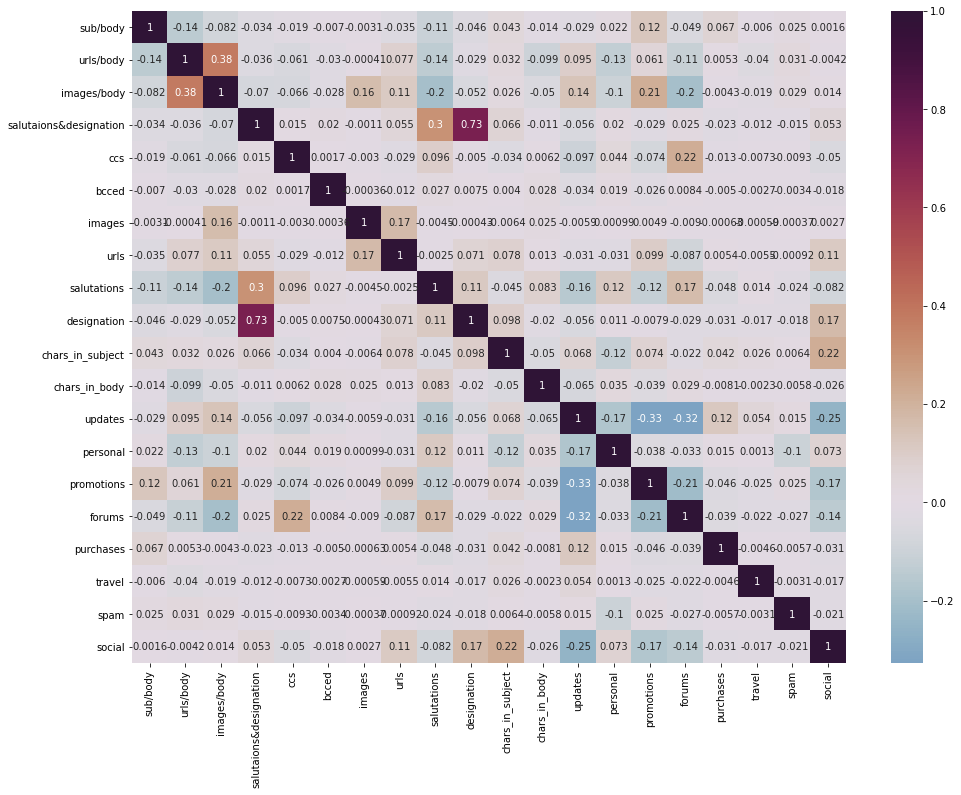

In [45]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(all_data.corr(),cmap = "twilight_shifted", annot=True, ax=ax, center=0)

In [46]:
all_data.head()

,sub/body,urls/body,images/body,salutaions&designation,date,org,tld,ccs,bcced,mail_type,...,chars_in_body,updates,personal,promotions,forums,purchases,travel,spam,social,date_hour
0,0.001839,0.001096,0.000157,0,Monday,researchgatemail,net,0,0,multipart/alternative,...,25556,0,1,0,0,0,0,0,1,08
1,0.002308,0.001606,0.000301,0,Thursday,no-ip,com,0,0,multipart/alternative,...,19930,1,1,0,0,0,0,0,0,16
2,5.250000,0.000000,0.000000,0,Thursday,mail,goodreads.com,0,0,multipart/mixed,...,4,0,1,0,0,0,0,0,1,01
3,0.000538,0.001771,0.001118,0,Friday,insideapple,apple.com,0,0,multipart/alternative,...,96568,0,0,1,0,0,0,0,0,08
4,0.000851,0.001745,0.000210,0,Thursday,twitter,com,0,0,multipart/alternative,...,95131,0,1,0,0,0,0,0,1,10



### Creating and encoding X and y vectors :

In [47]:
#Categorical Data
attributes = ['org','tld','mail_type','date','date_hour'] #Categorical data
cat_data_final =  all_data_final[attributes].fillna(value="None")
cat_data = all_data[attributes].fillna(value='None')

#Training and Testing
X = all_data[['ccs','bcced','images','urls','salutations','designation','chars_in_subject','chars_in_body','sub/body','urls/body','images/body']]

    #Data cleaning
X = X.fillna(value=0)

    #Encode other data
enc = OneHotEncoder(sparse=0, handle_unknown='ignore')
for att in attributes:
    enc.fit( cat_data[att].values.reshape(-1,1)[::10] ) #Fit

    X_tmp_enc = enc.transform( cat_data[att].values.reshape(-1,1) ) #Encoded data
    pd_X_tmp_enc = pd.DataFrame(X_tmp_enc, columns= [att +"_" + category for category in enc.categories_[0]]) 

    X = pd.concat([pd_X_tmp_enc, X], axis=1)

y = all_data[['updates','personal','promotions','forums','purchases','travel','spam','social']]



#Predicting
X_final = all_data_final[['ccs','bcced','images','urls','salutations','designation','chars_in_subject','chars_in_body','sub/body','urls/body','images/body']]

    #Data cleaning
X_final = X_final.fillna(value=0)
    #Encode other data
for att in attributes:
    enc.fit( cat_data[att].values.reshape(-1,1)[::10] ) #Fit
    X_tmp_enc = enc.transform( cat_data_final[att].values.reshape(-1,1) ) #Encoding data
    pd_X_tmp_enc = pd.DataFrame(X_tmp_enc, columns= [att +"_" + category for category in enc.categories_[0]]) 

    X_final = pd.concat([pd_X_tmp_enc, X_final], axis=1)



In [48]:
X.shape

(39671, 604)

### Classification :

In [49]:
N_SAMPLE = X.shape[0]
x_train, x_test, y_train, y_test = train_test_split(X.head(N_SAMPLE), y.head(N_SAMPLE), test_size=0.1, stratify=y.head(N_SAMPLE))

In [50]:
labels = ['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social']
grids = []
loss = []

for label in labels:
    print("For : " +label+" ...")
    #grid_params = {'base_estimator' : [DecisionTreeClassifier(max_depth=i) for i in [3,4,5]], 'n_estimators': range(20,201,30)}
    #grid_params = {'C':np.logspace(-1,1,3), 'gamma': np.logspace(2,4,3)}
    #grid_params = {'base_estimator' : [MLPClassifier(hidden_layer_sizes=[i,j,z],max_iter=20) for i in [20,40] for j in [10,20] for z in [10,20] ], 'n_estimators': range(20,81,30)}
    grid_params = {'n_estimators': range(60,181,20), 'criterion': ['gini','entropy']}
    grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_params, cv=3, verbose=1, scoring=make_scorer(log_loss,greater_is_better=0), n_jobs=4, return_train_score=True, refit=True)
    grid.fit(x_train, y_train[label])

    print("Best classifier : ", grid.best_estimator_ )
    print(classification_report(y_test[label], grid.best_estimator_.predict(x_test)))
    loss.append(log_loss(y_test[label], grid.best_estimator_.predict_proba(x_test)))
    print(loss[-1])
    grids.append(grid)
print("\n \nMean loss = ",np.mean(loss))

For : updates ...
Fitting 3 folds for each of 14 candidates, totalling 42 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  42 | elapsed:  6.4min finished
Best classifier :  RandomForestClassifier(n_estimators=160)
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2530
           1       0.92      0.92      0.92      1438

    accuracy                           0.94      3968
   macro avg       0.93      0.93      0.93      3968
weighted avg       0.94      0.94      0.94      3968

0.1897930723377197
For : personal ...
Fitting 3 folds for each of 14 candidates, totalling 42 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  42 | elapsed:  6.5min finished
Best classifier :  RandomForestClassifier(n_estimators=160)
              precision    recall  f1-score   support

           0       0.92      0

In [51]:
grids[4].best_estimator_

RandomForestClassifier(criterion='entropy')

### Predictions :

In [52]:
L = 0
for i in range(8):
    L+= log_loss(y_test[labels[i]], grids[i].best_estimator_.predict_proba(x_test)[:,1])
L/8

0.08890773771768544

In [53]:
predictions = pd.DataFrame()
for i,label in enumerate(labels):
    predictions[label] = grids[i].best_estimator_.predict_proba(X_final)[:,1]

predictions.to_csv("RForest_sample_submission_ml.csv", index=True, index_label='Id')